# Experimenting with Bactesting Investment Strategies

## Strategies

1. Buy and hold. You are given a lump sum and you invest it right away

2. Buy and hold, with buy downturns (aka buy the dip)



In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from backtesting_dev import DollarCostAveraging, DollarCostAveragingBuyDrawdown
from query_stocks import query_stock_prices
import random

import numpy as np
import plotly.graph_objects as go

In [60]:
plt.style.use('seaborn-v0_8-pastel')

random.seed(456)
# set seed above to 456
# expected profit: 24505.021713256847
# this is for down turn strategy as it buys on chance sometimes

In [61]:
DOWNLOAD_DATA = False

In [62]:
if DOWNLOAD_DATA:
    start = datetime.date(2014, 1, 1)
    end = datetime.date(2024, 1, 1)
    data = query_stock_prices(['VOO'], start_date=start, end_date=end)
    voo_df = data.to_frame("VOO").reset_index()
    voo_df.to_csv("data/voo_df.csv", index=False)

else:
    voo_df = pd.read_csv("data/voo_df.csv")
    voo_df['Date'] = pd.to_datetime(voo_df['Date'])

voo_df['sma_50'] = voo_df['VOO'].rolling(50).mean()

In [63]:
voo_df = voo_df.loc[(pd.Timestamp(2021, 1, 1) <= voo_df['Date'])]

## Basic Buy and Hold Strategy

tl;dr Immediately buy as much as possible. Don't think, just buy.

In [64]:
buyandhold = DollarCostAveraging('VOO', monies = 10000, income=1000)
buyandhold.run(data=voo_df)

753it [00:00, 1552.67it/s]


In [65]:
holdings = buyandhold.holdings.to_pandas()
profit_buyandhold = holdings['quantity']*(buyandhold.end_price - holdings['price'])
print("PROFIT: {:,.2f}".format(profit_buyandhold.sum())) #PROFIT: 102,904.19

PROFIT: 7,645.90


In [66]:
holdings

,symbol,price,quantity,date
0,VOO,339.029999,29.0,2021-01-04
1,VOO,340.179993,3.0,2021-01-29
2,VOO,349.589996,3.0,2021-02-26
3,VOO,364.299988,3.0,2021-03-31
4,VOO,383.570007,2.0,2021-04-30
5,VOO,386.130005,3.0,2021-05-28
6,VOO,393.519989,2.0,2021-06-30
7,VOO,403.149994,3.0,2021-07-30
8,VOO,415.049988,2.0,2021-08-31
9,VOO,394.399994,3.0,2021-09-30


In [67]:
ts_voo = voo_df.set_index('Date')

In [68]:
ts_holdings_1 = holdings.set_index('date') #.asfreq('D')

In [69]:
ts_voo = pd.concat([ts_voo, ts_holdings_1['price']], axis=1)

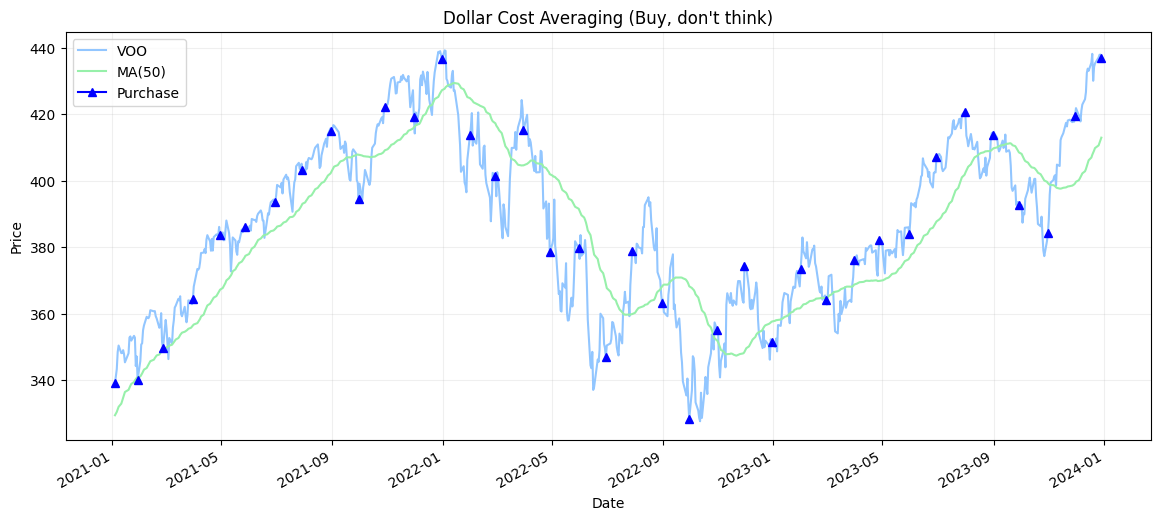

In [70]:
fig, ax = plt.subplots(figsize = (14, 6))
ts_voo['VOO'].plot(ax=ax, label='VOO')
ts_voo['sma_50'].plot(ax=ax, label='MA(50)')
ts_voo['price'].plot(marker='^', ax=ax, label='Purchase', color='blue')
ax.legend()
ax.set_title("Dollar Cost Averaging (Buy, don't think)")
ax.set_ylabel("Price")
ax.set_xlabel("Date")
ax.grid(alpha=0.2)


In [71]:
buyandhold.end_price*holdings['quantity'].sum() , buyandhold.contributions.sum()

(53289.598510742195,
 contributions       46000.000000
 available_funds    170906.785309
 dtype: float64)

In [72]:
buyandhold.end_price*holdings['quantity'].sum() / buyandhold.contributions.sum() - 1

contributions      0.158470
available_funds   -0.688195
dtype: float64

In [73]:
fig = go.Figure(
    layout=dict(
        title=go.layout.Title(text="Dollar Cost Averaging", xanchor='center', yanchor='top', x=0.5, y=0.9, font=dict(size=25)),
        height=550
        )
    )
fig.update_layout(xaxis_title="Date", yaxis_title="Price ($)", legend_title="Legend", font = dict(size=15))
#fig.update_layout(template='plotly_white')
#fig.update_layout(paper_bgcolor="white", plot_bgcolor="white")
# Add traces
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['VOO'],
                    mode='lines',
                    name='VOO'))
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['price'],
                    mode='markers', # lines+markers available too
                    marker=go.scatter.Marker(symbol='triangle-up', size=10, color='magenta'),
                    name='Purchases'))
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['sma_50'],
                    mode='lines',
                    line={'dash': 'dash'},
                    name='MA(50)'))
fig.show()

<Axes: xlabel='Date'>

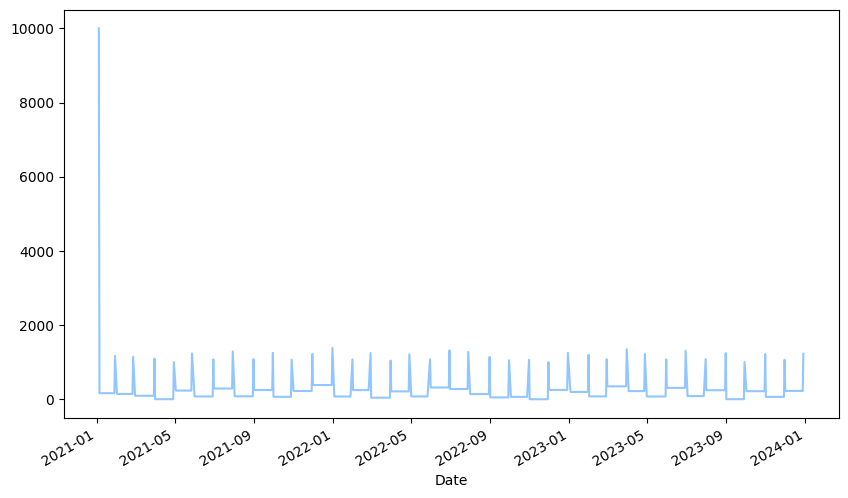

In [74]:
buyandhold.contributions['available_funds'].plot(figsize=(10, 6))

In [75]:
del ts_voo

## Downturn Strategy

In [76]:
drawdown = DollarCostAveragingBuyDrawdown('VOO', monies=10000, income=1000)
drawdown.run(data=voo_df)

753it [00:00, 1660.02it/s]


In [77]:
newholdings = drawdown.holdings.to_pandas()
profit_drawdown = newholdings['quantity']*(drawdown.end_price - newholdings['price'])
print("DRAWDOWN STRATEGY PROFIT: {:,.2f}".format(profit_drawdown.sum()))

DRAWDOWN STRATEGY PROFIT: 6,526.49


In [78]:
print("BUY AND HOLD PROFIT: {:,.2f}".format(profit_buyandhold.sum()))

BUY AND HOLD PROFIT: 7,645.90


In [79]:
ts_voo = voo_df.set_index('Date')

In [80]:
ts_holdings_2 = newholdings.set_index('date') #.asfreq('D')

In [81]:
ts_voo = pd.concat([ts_voo, ts_holdings_2[['price', 'quantity']]], axis=1)

In [82]:
ts_voo.head()

,VOO,sma_50,price,quantity
2021-01-04,339.029999,329.440203,339.029999,10.0
2021-01-05,341.260010,329.934003,NaN,NaN
2021-01-06,343.329987,330.447603,NaN,NaN
2021-01-07,348.459991,331.180803,NaN,NaN
2021-01-08,350.420013,331.973803,NaN,NaN


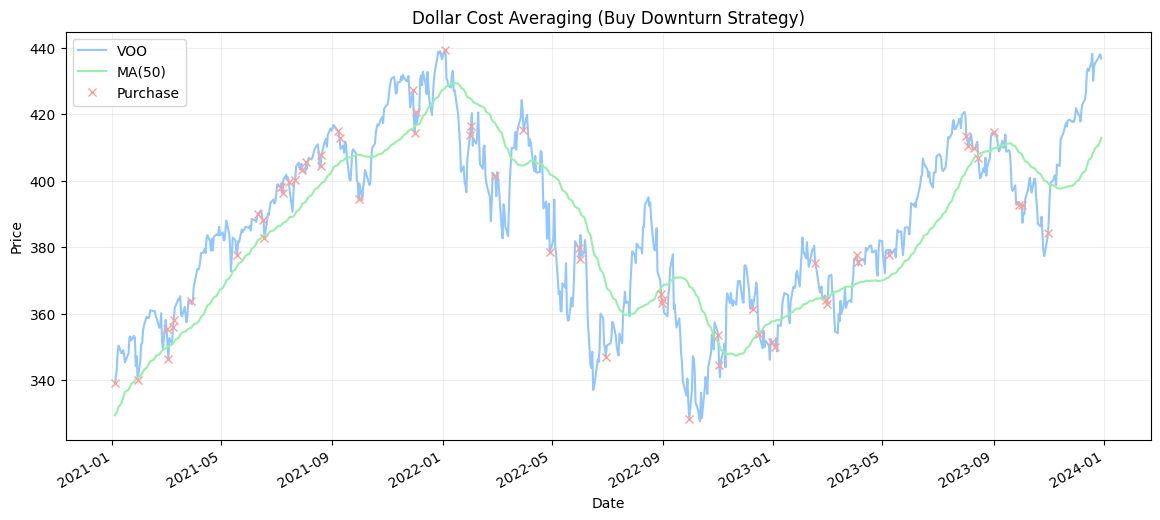

In [83]:
fig, ax = plt.subplots(figsize = (14, 6))
ts_voo['VOO'].plot(ax=ax, label='VOO')
ts_voo['sma_50'].plot(ax=ax, label='MA(50)')
ts_voo['price'].plot(marker='x', ax=ax, label='Purchase', markersize=6, linestyle='')
ax.legend()
ax.set_title("Dollar Cost Averaging (Buy Downturn Strategy)")
ax.set_ylabel("Price")
ax.set_xlabel("Date")
ax.grid(alpha=0.2)


In [84]:
drawdown.end_price*newholdings['quantity'].sum() , drawdown.contributions.sum()

(50231.99859619141,
 contributions      4.600000e+04
 available_funds    1.177911e+06
 dtype: float64)

In [85]:
drawdown.end_price*newholdings['quantity'].sum() / drawdown.contributions.sum() - 1

contributions      0.092000
available_funds   -0.957355
dtype: float64

In [86]:
fig = go.Figure(
    layout=dict(
        title=go.layout.Title(text="Dollar Cost Averaging with Downturn", xanchor='center', yanchor='top', x=0.5, y=0.9, font=dict(size=25)),
        height=550
        )
    )
fig.update_layout(xaxis_title="Date", yaxis_title="Price ($)", legend_title="Legend", font = dict(size=15))#fig.update_layout(template='plotly_white')
#fig.update_layout(paper_bgcolor="white", plot_bgcolor="white")
# Add traces
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['VOO'],
                    mode='lines',
                    name='VOO'))
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['price'],
                    mode='markers', # lines+markers available too
                    marker=go.scatter.Marker(symbol='triangle-up', size=10, color='magenta'),
                    name='Purchases'))
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['sma_50'],
                    mode='lines',
                    line={'dash': 'dash'},
                    name='MA(50)'))
fig.show()

In [87]:
# #combined plots
# N=100
# random_x = np.linspace(0, 5, N)
# random_y0 = np.random.randn(N) + 5
# random_y1 = np.random.randn(N)
# random_y2 = np.random.randn(N) - 5
# fig = go.Figure()
# # Add traces
# fig.add_trace(go.Line(x=random_x, y=random_y0))
# fig.add_trace(go.Scatter(x=random_x, y=random_y1,
#                     mode='markers',
#                     name='markers'))
# fig.add_trace(go.Scatter(x=random_x, y=random_y2,
#                     mode='lines',
#                     name='lines'))
# fig.show()

In [88]:
#help(go.Scatter)

<Axes: >

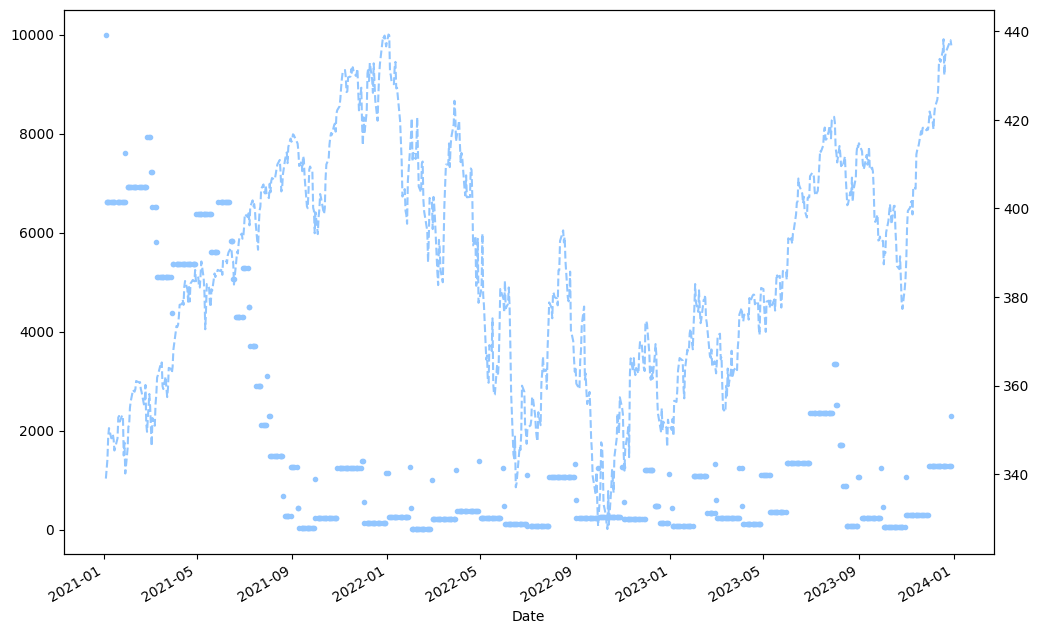

In [93]:
fig, ax1 = plt.subplots(figsize=(12, 8))

drawdown.contributions['available_funds'].plot(ax=ax1, marker='.', linestyle='')
#plt.plot_date(x = drawdown.contributions.index, y=drawdown.contributions['available_funds'], fmt='x')

ax2 = ax1.twinx()
#ts_voo['quantity'].fillna(0).cumsum().plot(ax=ax2)
ts_voo['VOO'].plot(ax=ax2, linestyle='--')

In [90]:
drawdown.contributions

,contributions,available_funds
Date,,
2021-01-04,10000,10000.000000
2021-01-05,0,6609.700012
2021-01-06,0,6609.700012
2021-01-07,0,6609.700012
2021-01-08,0,6609.700012
...,...,...
2023-12-22,0,1294.490112
2023-12-26,0,1294.490112
2023-12-27,0,1294.490112


In [91]:
#drawdown.holdings.to_pandas()['quantity'].cumsum()
ts_voo['quantity'].fillna(0).cumsum()

2021-01-04     10.0
2021-01-05     10.0
2021-01-06     10.0
2021-01-07     10.0
2021-01-08     10.0
              ...  
2023-12-22    115.0
2023-12-26    115.0
2023-12-27    115.0
2023-12-28    115.0
2023-12-29    115.0
Name: quantity, Length: 753, dtype: float64